<h1>Машинне навчання</h1>
<p>Ю.С. Процик. Курс лекцій</p>
<div align="right"><em>Cформовано на основі <a href="https://mlcourse.ai">відкритого курсу</a> Юрія Кашницького</em></div>

# <center>Тема 9. Навчання на гігабайтах даних з Vowpal Wabbit</center>

## План
1. [Стохастичний градієнтний спуск і онлайн-підхід до навчання](#1.-Стохастичний-градієнтний-спуск-і-онлайн\-підхід-до-навчання)
    - [Стохастичний градієнтний спуск](#Стохастичний-градієнтний-спуск)
    - [Онлайн-підхід до навчання](#Онлайн\-підхід-до-навчання)


2. [Робота з категоріальними ознаками: Label Encoding, One-Hot Encoding, Hashing trick](#2.-Робота-з-категоріальними-ознаками:-Label-Encoding,-One\-Hot-Encoding,-Hashing-trick)
    - [Label Encoding](#Label-Encoding)
    - [One-Hot Encoding](#One\-Hot-Encoding)
    - [Хешування ознак (Hashing trick)](#Хешування-ознак-\(Hashing-trick\))


3. [Бібліотека Vowpal Wabbit](#3.-Бібліотека-Vowpal-Wabbit)
    - [Новини. Бінарна класифікація](#Новини.-Бінарна-класифікація)
    - [Новини. Багатокласова класифікація](#Новини.-Багатокласова-класифікація)
    - [Рецензії до фільмів IMDB](#Рецензії-до-фільмів-IMDB)


4. [Корисні ресурси](#4.-Корисні-ресурси)

Ось ми поступово і дійшли до просунутих методів машинного навчання, сьогодні обговоримо, як взагалі підступитися до навчання моделі, якщо даних гігабайти і десятки гігабайт.
Обговоримо прийоми, що дозволяють це робити: стохастичний градієнтний спуск (SGD) і хешування ознак, подивимося на приклади застосування бібліотеки Vowpal Wabbit.

Спочатку імпортуємо відразу всі потрібні бібліотеки

In [1]:
import warnings
import os
import re
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.datasets import fetch_20newsgroups, load_files
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, log_loss
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

In [2]:
warnings.filterwarnings('ignore')

## 1. Стохастичний градієнтний спуск і онлайн-підхід до навчання

### Стохастичний градієнтний спуск

Незважаючи на те, що градієнтний спуск – одна з перших тем, що вивчаються в теорії оптимізації і машинному навчанні, складно переоцінити важливість однієї його модифікації – стохастичного градієнтного спуску, який ми часто будемо називати просто SGD (Stochastic Gradient Descent).

Нагадаємо, що суть градієнтного спуску – мінімізувати функцію, роблячи невеликі кроки в напрямку найшвидшого спадання функції. Назву методу подарував той факт з математичного аналізу, що вектор $\large\nabla f = \left(\frac{\partial f}{\partial x_1}, \ldots, \frac{\partial f}{\partial x_n}\right)^T$ часткових похідних функції $f(x) = f(x_1, \ldots, x_n)$ задає напрямок найшвидшого зростання цієї функції. Значить, рухаючись в напрямку антиградієнта функції (вектора, протилежного градієнту), можна зменшувати її значення швидше за все.

Ідея градієнтного спуску: якщо задача – якомога швидше спуститися з гори на сноуборді, то потрібно в кожній точці вибирати максимальний нахил (якщо це сумісно з життям), тобто обчислювати антиградієнт.

**Приклад**

Задачу простої парної регресії можна розв'язувати за допомогою градієнтного спуску. Спрогнозуємо одну змінну за іншою – зріст за вагою, припускаючи, що ці змінні лінійно залежні. Будемо використовувати набір даних [SOCR](http://wiki.stat.ucla.edu/socr/index.php/SOCR_Data).

In [3]:
PATH_TO_ALL_DATA = '../data'
data_demo = pd.read_csv(os.path.join(PATH_TO_ALL_DATA,
                                     'weights_heights.csv'))

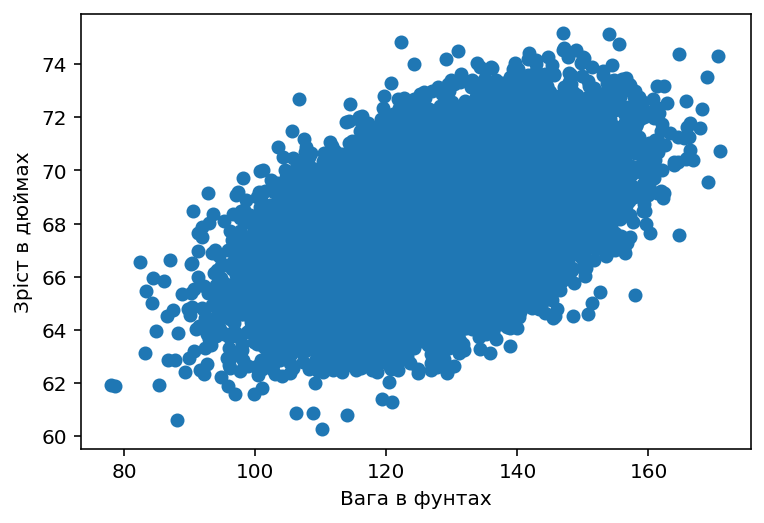

In [4]:
plt.scatter(data_demo['Weight'], data_demo['Height']);
plt.xlabel('Вага в фунтах')
plt.ylabel('Зріст в дюймах');

Дано вектор $x$ довжини $\ell$ – значення ваги для кожного спостереження (людини) і $y$ – вектор значень зросту для кожного спостереження (людини).

Задача: знайти такі ваги $w_0$ і $w_1$, щоб при прогнозуванні зросту за вагою у вигляді $y_i = w_0 + w_1 x_i$ (де $y_i$ – $i$-е значення зросту, $x_i$ – $i$-е значення ваги) мінімізувати квадратичну помилку (можна і середньоквадратичну, але константа $\displaystyle\frac{1}{\ell}$ погоди не робить, а $\displaystyle\frac{1}{2}$ заведена для краси):
$$ \large
SE(w_0, w_1) = \frac{1}{2}\sum_{i=1}^\ell(y_i - (w_0 + w_1x_{i}))^2 \rightarrow \min\limits_{w_0,w_1}
$$

Робити ми це будемо з допомогою градієнтного спуску, порахувавши часткові похідні функції $SE(w_0, w_1)$ по вагам в моделі – $w_0$ і $w_1$.
Ітеративна процедура навчання буде задаватися простими формулами оновлення ваг (міняємо ваги так, щоб робити невеликий, пропорційно малій константі $\eta$, крок в напрямку антиградієнта функції):

$$\large
\begin{array}{rcl}\displaystyle 
w_0^{(t+1)} = w_0^{(t)} -\left. \eta \frac{\partial SE}{\partial w_0}\right|_{t} \\\displaystyle  
w_1^{(t+1)} = w_1^{(t)} -\left. \eta \frac{\partial SE}{\partial w_1}\right|_{t} 
\end{array}
$$

Якщо обчислити часткові похідні, то отримаємо

$$\large
\begin{array}{rcl}\displaystyle  
w_0^{(t+1)} = w_0^{(t)} + \eta \sum\limits_{i=1}^{\ell}(y_i - w_0^{(t)} - w_1^{(t)}x_i) \\\displaystyle  
w_1^{(t+1)} = w_1^{(t)} + \eta \sum\limits_{i=1}^{\ell}(y_i - w_0^{(t)} - w_1^{(t)}x_i)x_i 
\end{array}
$$

І все це досить добре працює (в цій темі ми не будемо обговорювати проблеми локальних мінімумів, підбору кроку градієнтного спуску і т.д. – про це і так багато написано, можна звернутися до [розділу](http://www.deeplearningbook.org/contents/numerical.html) "Numeric Computation" книги "Deep Learning") поки даних не стає занадто багато. Проблема такого підходу в тому, що обчислення градієнта зводиться до сумування деяких величин для кожного об'єкта навчальної вибірки. Проблема в тому, що ітерацій алгоритму на практиці потрібно багато, а на кожній ітерації ваги перераховуються за формулою, в якій є сума по всій вибірці виду $\displaystyle\sum\limits_{i=1}^\ell$. А що якщо об'єктів у вибірці мільйони і мільярди?

Суть стохастичного градієнтного спуску – неформально, викинути знак суми з формул перерахунку ваг і оновлювати їх по одному об'єкту (або невеликій кількості). Тобто в нашому випадку

$$\large
\begin{array}{rcl}\displaystyle  
w_0^{(t+1)} = w_0^{(t)} + \eta (y_i - w_0^{(t)} - w_1^{(t)}x_i) \\\displaystyle  
w_1^{(t+1)} = w_1^{(t)} + \eta (y_i - w_0^{(t)} - w_1^{(t)}x_i)x_i 
\end{array}
$$

При такому підході на кожній ітерації вже зовсім не гарантований рух в напрямку найшвидшого спадання функції, і ітерацій може знадобитися на кілька порядків більше, ніж при звичайному градієнтному спуску. Зате перерахунок ваг на кожній ітерації робиться майже миттєво.

В якості ілюстрації візьмемо рисунок Ендрю Ина з його [курсу](https://www.coursera.org/learn/machine-learning) машинного навчання.

<img src='../img/sgd_convergence.png'>

На рисунку відображені лінії рівня деякою функції, мінімум якої ми шукаємо. Червона крива показує зміну ваг (на рисунку $\theta_0$ і $\theta_1$ відповідають $w_0$ і $w_1$ в нашому прикладі). За властивостями градієнта напрямок зміни в кожній точці буде перпендикулярний лініям рівня. При стохастичному підході на кожній ітерації ваги змінюються менш передбачувано, інколи навіть здається, що деякі кроки невдалі – відводять від шуканого мінімуму, але в результаті обидві процедури збігаються приблизно до одного розв'язку.

Збіжність стохастичного градієнтного спуску до того ж розв'язку, що і у градієнтного спуску, є одним з найважливіших фактів, доведених в теорії оптимізації. Зараз в епоху Big Data і Deep Learning частіше саме стохастичну версію називають градієнтним спуском.

### Онлайн-підхід до навчання

Стохастичний градієнтний спуск, будучи одним з методів оптимізації, дає цілком практичні рекомендації до навчання алгоритмів класифікації і регресії на великих вибірках – до сотень гігабайт (в залежності від наявної пам'яті).

У разі парної регресії, який ми розглянули, на диску можна зберігати навчальну вибірку $(X,y)$ і, не завантажуючи її в оперативну пам'ять (вона може просто не поміститися), зчитувати об'єкти по одному та оновлювати ваги:

$$\large
\begin{array}{rcl}\displaystyle  
w_0^{(t+1)} = w_0^{(t)} + \eta (y_i - w_0^{(t)} - w_1^{(t)}x_i) \\\displaystyle  
w_1^{(t+1)} = w_1^{(t)} + \eta (y_i - w_0^{(t)} - w_1^{(t)}x_i)x_i 
\end{array}
$$

Після обробки всіх об'єктів навчальної вибірки, функціонал, який ми оптимізуємо (квадратична помилка в задачі регресії або, наприклад, логістична – в задачі класифікації) зменшиться, але часто потрібно кілька десятків проходів по вибірці, щоб досягнути достатнього результату зменшення.

Такий підхід до навчання моделей часто називають *онлайн-навчанням*.

В цій лекції ми не розглядаємо багатьох нюансів стохастичної оптимізації. Фундаментально вивчити цю тему можна по книзі [Stephen Boyd "Convex Optimization"](https://web.stanford.edu/~boyd/cvxbook/bv_cvxbook.pdf). Перейдемо швидше до бібліотеки Vowpal Wabbit, за допомогою якої можна навчати прості моделі на величезних вибірках за рахунок стохастичної оптимізації і ще одного трюку – хешування ознак, про який піде мова далі.

У бібліотеці Scikit-learn класифікатори та регресори, які навчають стохастичним градієнтним спуском, реалізовані класами `SGDClassifier` і` SGDRegressor` з `sklearn.linear_model`.

## 2. Робота з категоріальними ознаками: Label Encoding, One-Hot Encoding, Hashing trick

### Label Encoding
Переважна більшість методів класифікації і регресії сформульовані в термінах евклідових або метричних просторів, тобто передбачають подання даних у вигляді дійснозначних векторів однакової розмірності. Однак, в реальних даних часто зустрічаються категоріальні ознаки, які приймають дискретні значення, такі як так/ні або січень/лютий/.../грудень. Обговоримо те, як працювати з такими даними, зокрема за допомогою лінійних моделей, і що робити, якщо категоріальних ознак багато, та ще й у кожної купа унікальних значень.

Розглянемо вибірку [UCI bank](https://archive.ics.uci.edu/ml/datasets/bank+marketing), в якій велика частина ознак – категоріальні.

In [5]:
df = pd.read_csv(os.path.join(PATH_TO_ALL_DATA, 'UCI_bank/bank_train.csv'))
labels = pd.read_csv(os.path.join(PATH_TO_ALL_DATA,
                                  'UCI_bank/bank_train_target.csv'), 
                     header=None)

df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,student,single,high.school,no,no,no,telephone,jun,mon,901,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1
1,46,admin.,married,university.degree,no,yes,no,cellular,aug,tue,208,2,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
2,49,blue-collar,married,basic.4y,unknown,yes,yes,telephone,jun,tue,131,5,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1
3,31,technician,married,university.degree,no,no,no,cellular,jul,tue,404,1,999,0,nonexistent,-2.9,92.469,-33.6,1.044,5076.2
4,42,housemaid,married,university.degree,no,yes,no,telephone,nov,mon,85,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8


Неважко помітити, що досить багато ознак в цьому наборі даних не представлені числами. У такому вигляді дані ще нам не підходять – ми не зможемо застосовувати переважну більшість доступних методів.

Щоб знайти рішення, давайте розглянемо ознаку "education":

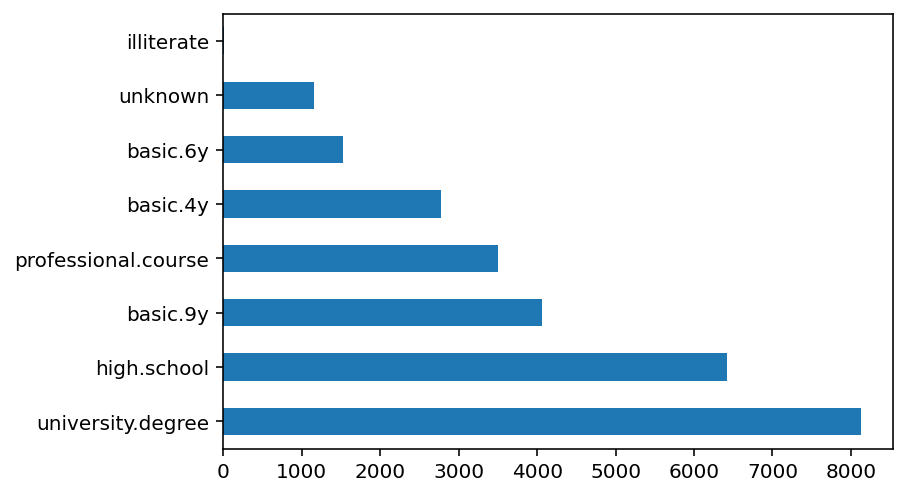

In [6]:
df['education'].value_counts().plot.barh();

Природним рішенням такої проблеми було б однозначне відображення кожного значення в унікальне число. Наприклад, ми могли б перетворити `university.degree` в 0, а `basic.9y` в 1. Цю просту операцію доводиться робити часто, тому в модулі `preprocessing` бібліотеки `sklearn` саме для цієї задачі реалізований клас `LabelEncoder`:

In [7]:
label_encoder = LabelEncoder()

Метод `fit` цього класу знаходить все унікальні значення і будує таблицю для відповідності кожної категорії деякому числа, а метод `transform` безпосередньо перетворює значення в числа. Після `fit` у `label_encoder` буде доступне поле `classes_`, що містить всі унікальні значення. Пронумеруємо їх, щоб переконатися, що перетворення виконано вірно.

{0: 'basic.4y', 1: 'basic.6y', 2: 'basic.9y', 3: 'high.school', 4: 'illiterate', 5: 'professional.course', 6: 'university.degree', 7: 'unknown'}


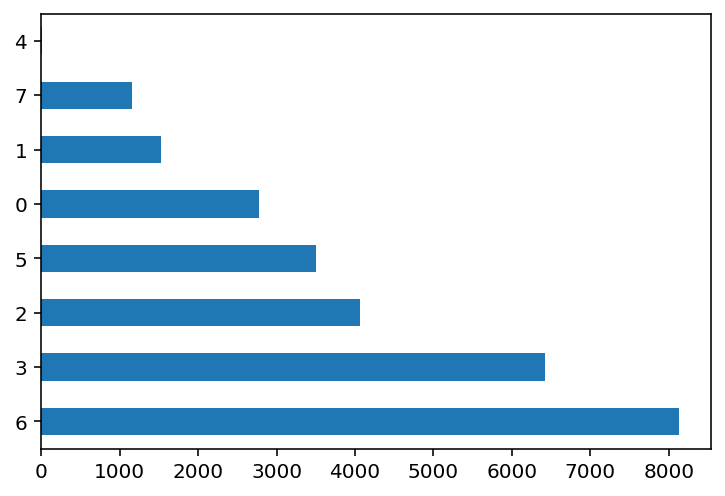

In [8]:
mapped_education = pd.Series(label_encoder.fit_transform(df['education']))
mapped_education.value_counts().plot.barh()
print(dict(enumerate(label_encoder.classes_)))

Що станеться, якщо у нас з'являться дані з іншими категоріями?

In [9]:
try:
    label_encoder.transform(df['education'].replace('high.school', 'high_school'))
except Exception as e:
    print('Error:', e)

Error: y contains previously unseen labels: 'high_school'


Таким чином, при використанні цього підходу ми завжди повинні бути впевнені, що ознака не може приймати невідомих раніше значень. До цієї проблеми ми повернемося трохи пізніше, а зараз замінимо весь стовпець "education" на перетворений:

In [10]:
df['education'] = mapped_education
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,student,single,3,no,no,no,telephone,jun,mon,901,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1
1,46,admin.,married,6,no,yes,no,cellular,aug,tue,208,2,999,0,nonexistent,1.4,93.444,-36.1,4.963,5228.1
2,49,blue-collar,married,0,unknown,yes,yes,telephone,jun,tue,131,5,999,0,nonexistent,1.4,94.465,-41.8,4.864,5228.1
3,31,technician,married,6,no,no,no,cellular,jul,tue,404,1,999,0,nonexistent,-2.9,92.469,-33.6,1.044,5076.2
4,42,housemaid,married,6,no,yes,no,telephone,nov,mon,85,1,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8


Продовжимо перетворення для всіх стовпців, що мають тип `object` – саме цей тип задається в pandas для таких даних.

In [11]:
df.columns[df.dtypes == 'object'].union(['education'])

Index(['contact', 'day_of_week', 'default', 'education', 'housing', 'job',
       'loan', 'marital', 'month', 'poutcome'],
      dtype='object')

In [12]:
categorical_columns = df.columns[df.dtypes == 'object'].union(['education'])
for column in categorical_columns:
    df[column] = label_encoder.fit_transform(df[column])
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,26,8,2,3,0,0,0,1,4,1,901,1,999,0,1,1.4,94.465,-41.8,4.961,5228.1
1,46,0,1,6,0,2,0,0,1,3,208,2,999,0,1,1.4,93.444,-36.1,4.963,5228.1
2,49,1,1,0,1,2,2,1,4,3,131,5,999,0,1,1.4,94.465,-41.8,4.864,5228.1
3,31,9,1,6,0,0,0,0,3,3,404,1,999,0,1,-2.9,92.469,-33.6,1.044,5076.2
4,42,3,1,6,0,2,0,1,7,1,85,1,999,0,1,-0.1,93.200,-42.0,4.191,5195.8


Основна проблема такого подання полягає в тому, що числовий код створив евклідове представлення для даних.

Наприклад, нами неявним чином була введена алгебра над значеннями роботи – ми можемо відняти роботу клієнта 1 від роботи клієнта 2:

In [13]:
df.loc[1].job - df.loc[2].job

-1.0

Звичайно ж, ця операція не має ніякого сенсу. Але саме на цьому базуються метрики близькості об'єктів, що робить безглуздим застосування методу найближчого сусіда на даних в такому вигляді. Аналогічним чином, ніякого сенсу не матиме застосування лінійних моделей. Переконаємося в цьому:

In [14]:
def logistic_regression_accuracy_on(dataframe, labels):
    features = dataframe.to_numpy()
    train_features, test_features, train_labels, test_labels = \
        train_test_split(features, labels)

    logit = LogisticRegression()
    logit.fit(train_features, train_labels)
    return classification_report(test_labels, logit.predict(test_features))

print(logistic_regression_accuracy_on(df[categorical_columns], labels))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94      6157
           1       0.00      0.00      0.00       742

    accuracy                           0.89      6899
   macro avg       0.45      0.50      0.47      6899
weighted avg       0.80      0.89      0.84      6899



Для того, щоб ми змогли застосовувати лінійні моделі на таких даних нам необхідний інший метод, який називається One-Hot Encoding

### One-Hot Encoding

Припустимо, що деяка ознака може приймати 10 різних значень. В цьому випадку one-hot encoding має на увазі створення 10 ознак, всі з яких дорівнюють нулю *за винятком однієї*. На позицію, що відповідає числовому значенню ознаки ми ставимо 1:

In [15]:
one_hot_example = pd.DataFrame([{i: 0 for i in range(10)}])
one_hot_example.loc[0, 6] = 1
one_hot_example

,0,1,2,3,4,5,6,7,8,9
0,0,0,0,0,0,0,1,0,0,0


Ця техніка реалізована в `sklearn.preprocessing` в класі `OneHotEncoder`. За замовчуванням `OneHotEncoder` перетворює дані в розріджену матрицю, щоб не витрачати пам'ять на зберігання численних нулів. Однак в цьому прикладі розмір даних не є для нас проблемою, тому ми будемо використовувати "щільне" представлення.

In [16]:
onehot_encoder = OneHotEncoder(sparse=False)

In [17]:
encoded_categorical_columns = pd.DataFrame(onehot_encoder.fit_transform(df[categorical_columns]))
encoded_categorical_columns.head()

,0,1,2,3,4,5,6,7,8,9,...,43,44,45,46,47,48,49,50,51,52
0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


Ми отримали 53 стовпці – саме стільки різних унікальних значень можуть приймати категоріальні стовпці вихідної вибірки. Перетворені за допомогою One-Hot Encoding дані починають набувати змісту для лінійної моделі:

In [18]:
print(logistic_regression_accuracy_on(encoded_categorical_columns, labels))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95      6124
           1       0.68      0.19      0.29       775

    accuracy                           0.90      6899
   macro avg       0.79      0.59      0.62      6899
weighted avg       0.88      0.90      0.87      6899



### Хешування ознак (Hashing trick)

Реальні дані можуть виявитися набагато динамічнішими, і ми не завжди можемо розраховувати, що категоріальні ознаки не прийматимуть нових значень. Все це сильно ускладнює використання вже навчених моделей на нових даних. Крім того, `LabelEncoder` передбачає попередній аналіз всієї вибірки і зберігання побудованих відображень в пам'яті, що ускладнює роботу в режимі великих даних.

Для вирішення цих проблем існує більш простий підхід до векторизації категоріальних ознак, що базується на хешуванні, і відомий як hashing trick.

Хеш-функції можуть допомогти нам в задачі пошуку унікальних кодів для різних значень ознаки, наприклад:

In [19]:
for s in ('university.degree', 'high.school', 'illiterate'):
    print(s, '->', hash(s))

university.degree -> 6656748896379699328
high.school -> 4980699703138926094
illiterate -> -8861713015613307351


Від'ємні і настільки великі за модулем значення нам не підійдуть. Обмежимо область значень хеш-функції:

In [20]:
hash_space = 25
for s in ('university.degree', 'high.school', 'illiterate'):
    print(s, '->', hash(s) % hash_space)

university.degree -> 3
high.school -> 19
illiterate -> 24


Уявімо, що у нас в вибірці є неодружений студент, якому подзвонили в понеділок, тоді його вектор ознак буде сформований аналогічно One-Hot Encoding, але в єдиному просторі фіксованого розміру для всіх ознак:

In [21]:
hashing_example = pd.DataFrame([{i: 0.0 for i in range(hash_space)}])
for s in ('job=student', 'marital=single', 'day_of_week=mon'):
    print(s, '->', hash(s) % hash_space)
    hashing_example.loc[0, hash(s) % hash_space] = 1
hashing_example

job=student -> 12
marital=single -> 13
day_of_week=mon -> 8


,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Варто звернути увагу, що в цьому прикладі хешувалися не тільки значення ознак, а пари **назва ознаки + значення ознаки**. Це необхідно, щоб розділити однакові значення різних ознак між собою, наприклад:

In [22]:
assert hash('no') == hash('no')
assert hash('housing=no') != hash('loan=no')

Чи може статися колізія хеш-функції, тобто співпадіння кодів для двох різних значень? Неважко довести, що при достатньому розмірі простору хешування це відбувається рідко, але навіть в тих випадках, коли таке відбувається, це не буде приводити до істотного погіршення якості класифікації або регресії.

<img src="../img/hashing_trick.jpg">

Можливо, ви запитаєте: "а що взагалі відбувається?", і здасться, що при хешуванні ознак страждає здоровий глузд. Можливо, але ця евристика – по суті, єдиний підхід до того, щоб працювати з категоріальними ознаками, у яких багато унікальних значень. Більше того, ця техніка себе добре зарекомендувала на практиці. Детальніше про хешування ознак (learning to hash) можна почитати в [цьому](https://arxiv.org/abs/1509.05472) огляді, а також в [матеріалах](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture06-linclass.pdf) Євгенія Соколова.

## 3. Бібліотека Vowpal Wabbit

Vowpal Wabbit (VW) є однією з найбільш широко використовуваних бібліотек в індустрії. Її відрізняє висока швидкість роботи і підтримка великої кількості різних режимів навчання. Особливий інтерес для великих і високорозмірних даних представляє онлайн-навчання – найсильніша сторона бібліотеки.
Також реалізовано хешування ознак, і Vowpal Wabbit відмінно підходить для роботи з текстовими даними.

Основним інтерфейсом для роботи з VW є shell.

In [23]:
!vw --help

driver:
  --onethread           Disable parse thread
VW options:
  --ring_size arg (=256, ) size of example ring
  --strict_parse           throw on malformed examples
Update options:
  -l [ --learning_rate ] arg Set learning rate
  --power_t arg              t power value
  --decay_learning_rate arg  Set Decay factor for learning_rate between passes
  --initial_t arg            initial t value
  --feature_mask arg         Use existing regressor to determine which 
                             parameters may be updated.  If no 
                             initial_regressor given, also used for initial 
                             weights.
Weight options:
  -i [ --initial_regressor ] arg  Initial regressor(s)
  --initial_weight arg            Set all weights to an initial value of arg.
  --random_weights                make initial weights random
  --normal_weights                make initial weights normal
  --truncated_normal_weights      make initial weights truncated normal
  --sp

Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = 
num sources = 1


Feature options:
  --hash arg                      how to hash the features. Available options: 
                                  strings, all
  --hash_seed arg (=0, )          seed for hash function
  --ignore arg                    ignore namespaces beginning with character 
                                  <arg>
  --ignore_linear arg             ignore namespaces beginning with character 
                                  <arg> for linear terms only
  --keep arg                      keep namespaces beginning with character 
                                  <arg>
  --redefine arg                  redefine namespaces beginning with characters
                                  of std::string S as namespace N. <arg> shall 
                                  be in form 'N:=S' where := is operator. Empty
                                  N or S are treated as default namespace. Use 
                                  ':' as a wildcard in S.
  -b [ --bit_precision ] arg      number of bit

Vowpal Wabbit зчитує дані з файлу або стандартного вводу (stdin) в форматі, який має наступний вигляд:

`[Label] [Importance] [Tag]|Namespace Features |Namespace Features ... |Namespace Features`

`Namespace=String[:Value]`

`Features=(String[:Value] )*`

де [] позначає необов'язкові елементи, а (...)\* означає повторення невизначену кількість разів.

- **Label** є числом, "правильною" відповіддю. У випадку класифікації зазвичай приймає значення 1/-1, а у випадку регресії деяке дійсне число
- **Importance** є числом і відповідає за вагу прикладу при навчанні. Це дозволяє боротися з проблемою незбалансованих даних
- **Tag** є деяким рядком без пробілів і відповідає за певну "назву" прикладу, яка зберігається при прогнозуванні відповіді. Для того, щоб відокремити Tag від Importance краще починати Tag з символу '.
- **Namespace** служить для створення окремих просторів ознак. В аргументах Namespace іменуються по першій букві, це потрібно враховувати при виборі їх назв
- **Features** є безпосередньо ознаками об'єкта всередині **Namespace**. Ознаки за замовчуванням мають вагу 1.0, але її можна перевизначити, наприклад feature: 0.1.


Наприклад, під такий формат підходить наступний рядок:

```
1 1.0 |Subject WHAT car is this |Organization University of Maryland:0.5 College Park
```

VW є прекрасним інструментом для роботи з текстовими даними. Переконаємося в цьому за допомогою вибірки 20newsgroups, що містить листи з 20 різних тематичних розсилок.


### Новини. Бінарна класифікація

In [24]:
newsgroups = fetch_20newsgroups(PATH_TO_ALL_DATA)


                            Default: mtr
Contextual Bandit Exploration with Action Dependent Features:
  --cb_explore_adf             Online explore-exploit for a contextual bandit 
                               problem with multiline action dependent features
  --epsilon arg                minimum exploration probability
  --rnd arg                    rnd based exploration
  --rnd_alpha arg (=0.1, )     ci width for rnd (bigger => more exploration on 
                               repeating features)
  --rnd_invlambda arg (=0.1, ) covariance regularization strength rnd (bigger 
                               => more exploration on new features)
Contextual Bandit Exploration with Action Dependent Features:
  --cb_explore_adf      Online explore-exploit for a contextual bandit problem 
                        with multiline action dependent features
  --epsilon arg         epsilon-greedy exploration
  --softmax             softmax exploration
  --lambda arg (=1, )   parameter for sof

In [25]:
newsgroups['target_names']

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

Розглянемо перший текстовий документ цієї колекції:

In [26]:
text = newsgroups['data'][0]
target = newsgroups['target_names'][newsgroups['target'][0]]

print('-----')
print(target)
print('-----')
print(text.strip())
print('----')

-----
rec.autos
-----
From: lerxst@wam.umd.edu (where's my thing)
Subject: WHAT car is this!?
Nntp-Posting-Host: rac3.wam.umd.edu
Organization: University of Maryland, College Park
Lines: 15

 I was wondering if anyone out there could enlighten me on this car I saw
the other day. It was a 2-door sports car, looked to be from the late 60s/
early 70s. It was called a Bricklin. The doors were really small. In addition,
the front bumper was separate from the rest of the body. This is 
all I know. If anyone can tellme a model name, engine specs, years
of production, where this car is made, history, or whatever info you
have on this funky looking car, please e-mail.

Thanks,
- IL
   ---- brought to you by your neighborhood Lerxst ----
----


Приведемо дані до формату Vowpal Wabbit, при цьому залишаючи тільки слова не коротші ніж 3 символа. Тут ми не виконуємо багато важливих в аналізі текстів процедур (стемінг і лематизацію), але, як побачимо, задача і так буде добре  розв'язуватися.

In [27]:
def to_vw_format(document, label=None):
    return str(label or '') + ' |text ' + ' '.join(re.findall('\w{3,}', document.lower())) + '\n'

to_vw_format(text, 1 if target == 'rec.autos' else -1)

'1 |text from lerxst wam umd edu where thing subject what car this nntp posting host rac3 wam umd edu organization university maryland college park lines was wondering anyone out there could enlighten this car saw the other day was door sports car looked from the late 60s early 70s was called bricklin the doors were really small addition the front bumper was separate from the rest the body this all know anyone can tellme model name engine specs years production where this car made history whatever info you have this funky looking car please mail thanks brought you your neighborhood lerxst\n'

Розіб'ємо вибірку на навчальну і тестову і запишемо в файл перетворені таким чином документи. Будемо вважати документ позитивним, якщо він відноситься до розсилки про автомобілі **rec.autos**. Так ми побудуємо модель, яка відрізняє листи про автомобілі від інших:

In [28]:
all_documents = newsgroups['data']
all_targets = [1 if newsgroups['target_names'][target] == 'rec.autos' 
               else -1 for target in newsgroups['target']]

In [29]:
train_documents, test_documents, train_labels, test_labels = \
    train_test_split(all_documents, all_targets, random_state=7)
    
with open(os.path.join(PATH_TO_ALL_DATA, '20news_train.vw'), 'w', encoding='utf-8') as vw_train_data:
    for text, target in zip(train_documents, train_labels):
        vw_train_data.write(to_vw_format(text, target))
with open(os.path.join(PATH_TO_ALL_DATA, '20news_test.vw'), 'w', encoding='utf-8') as vw_test_data:
    for text in test_documents:
        vw_test_data.write(to_vw_format(text))

Запустимо Vowpal Wabbit на сформованому файлі. Ми розв'язуємо задачу класифікації, тому будемо використовувати функцію втрат hinge (лінійний SVM). Побудовану модель збережемо у відповідний файл `20news_model.vw`:

In [30]:
!vw -d $PATH_TO_ALL_DATA/20news_train.vw \
 --loss_function hinge -f $PATH_TO_ALL_DATA/20news_model.vw

final_regressor = ../data/20news_model.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = ../data/20news_train.vw
num sources = 1
Enabled reductions: gd, scorer
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0  -1.0000   0.0000      157
0.911276 0.822551            2            2.0  -1.0000  -0.1774      159
0.605793 0.300311            4            4.0  -1.0000  -0.3994       92
0.419594 0.233394            8            8.0  -1.0000  -0.8167      129
0.313998 0.208402           16           16.0  -1.0000  -0.6509      108
0.196014 0.078029           32           32.0  -1.0000  -1.0000      115
0.183158 0.170302           64           64.0  -1.0000  -0.7072      114
0.261046 0.338935          128          128.0   1.0000  -0.7900      110
0.262910 0.264774          256          256.0  -1.0000

Модель навчена. VW виводить досить багато корисної інформації в процесі навчання (проте, її можна погасити, якщо задати параметр --quiet). Детально вивід діагностичної інформації розібраний в документації VW на GitHub – [тут](https://github.com/JohnLangford/vowpal_wabbit/wiki/Tutorial#vws-diagnostic-information). Зверніть увагу, що значення average loss знижувалися з кожною наступною ітерацією. Для обчислення функції втрат VW використовує ще не переглянуті приклади, тому, як правило, ця оцінка є коректною. Застосуємо навчену модель на тестовій вибірці, зберігаючи передбачення в файл за допомогою опції -p:

In [31]:
!vw -i $PATH_TO_ALL_DATA/20news_model.vw -t -d $PATH_TO_ALL_DATA/20news_test.vw \
-p $PATH_TO_ALL_DATA/20news_test_predictions.txt

only testing
predictions = ../data/20news_test_predictions.txt
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = ../data/20news_test.vw
num sources = 1
Enabled reductions: gd, scorer
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
    n.a.     n.a.            1            1.0  unknown   1.0000      349
    n.a.     n.a.            2            2.0  unknown  -1.0000       50
    n.a.     n.a.            4            4.0  unknown  -1.0000      251
    n.a.     n.a.            8            8.0  unknown  -1.0000      237
    n.a.     n.a.           16           16.0  unknown  -0.8978      106
    n.a.     n.a.           32           32.0  unknown  -1.0000      964
    n.a.     n.a.           64           64.0  unknown  -1.0000      261
    n.a.     n.a.          128          128.0  unknown   0.4621       82
    n.a.     n.a.          256    

Завантажимо отримані передбачення, обчислимо AUC і відобразимо ROC-криву:

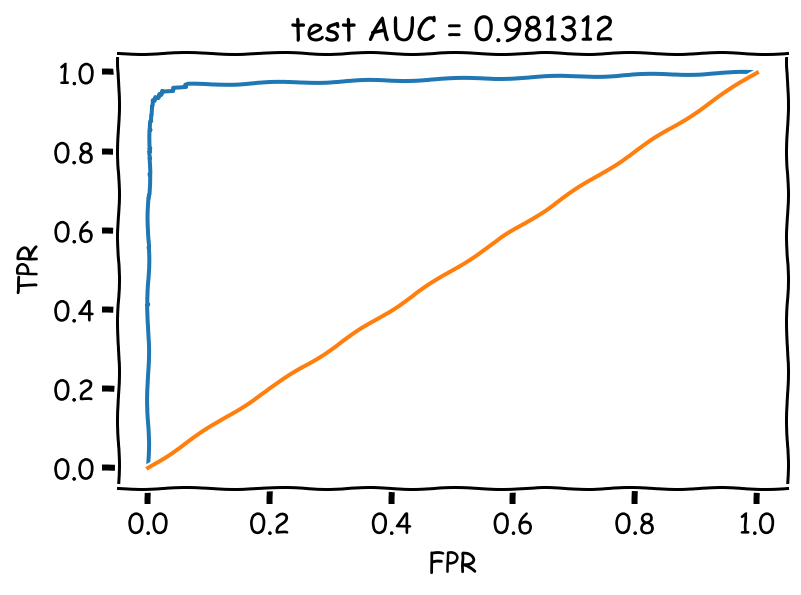

In [32]:
with open(os.path.join(PATH_TO_ALL_DATA, 
                       '20news_test_predictions.txt')) as pred_file:
    test_prediction = [float(label) 
                       for label in pred_file.readlines()]

auc = roc_auc_score(test_labels, test_prediction)
rcurve = roc_curve(test_labels, test_prediction)

with plt.xkcd():
    plt.plot(rcurve[0], rcurve[1]);
    plt.plot([0,1], [0,1])
    plt.xlabel('FPR'); plt.ylabel('TPR'); 
    plt.title('test AUC = %f' % (auc)); 
    plt.axis([-0.05,1.05,-0.05,1.05]);

Отримане значення AUC говорить про високу якість класифікації.

### Новини. Багатокласова класифікація

Використовуємо ту ж вибірку, що в попередній частині, але розв'язуємо задачу багатокласової класифікації. `Vowpal Wabbit` вимагає, щоб мітки класів були розподілені від 1 до K, де K – кількість класів у задачі класифікації (в нашому випадку – 20). Тому доведеться застосувати `LabelEncoder`, та ще й потім додати 1 (`LabelEncoder` переводить мітки в діапазон від 0 до K-1).

In [33]:
all_documents = newsgroups['data']
topic_encoder = LabelEncoder()
all_targets_mult = topic_encoder.fit_transform(newsgroups['target']) + 1

**Вибірки будуть ті самі, а мітки поміняються, train_labels_mult і test_labels_mult – вектори міток від 1 до 20.**

In [34]:
train_documents, test_documents, train_labels_mult, test_labels_mult = \
    train_test_split(all_documents, all_targets_mult, random_state=7)
    
with open(os.path.join(PATH_TO_ALL_DATA, 
                       '20news_train_mult.vw'), 'w', encoding='utf-8') as vw_train_data:
    for text, target in zip(train_documents, train_labels_mult):
        vw_train_data.write(to_vw_format(text, target))
with open(os.path.join(PATH_TO_ALL_DATA, 
                       '20news_test_mult.vw'), 'w', encoding='utf-8') as vw_test_data:
    for text in test_documents:
        vw_test_data.write(to_vw_format(text))        

Навчимо Vowpal Wabbit в режимі багатокласової класифікації, передавши параметр `oaa` (від "one against all"), що дорівнює кількості класів. Також перерахуємо параметри, які можна поналаштовувати, і від яких може досить сильно залежати якість моделі (більш повна інформація – в офіційному [підручнику](https://github.com/JohnLangford/vowpal_wabbit/wiki/Tutorial) по Vowpal Wabbit):
 - швидкість (темп) навчання (-l, за замовчуванням 0.5) – коефіцієнт перед зміною ваг моделі при кожній зміні
 - ступінь зменшення швидкості навчання (--power_t, за замовчуванням 0.5) – на практиці перевірено, що якщо швидкість навчання зменшується при збільшенні кількості ітерацій стохастичного градієнтного спуску, то мінімум функції знаходиться краще
 - функція втрат (--loss_function) – від неї, по суті, залежить весь алгоритм навчання. Про функції втрат в [документації](https://github.com/JohnLangford/vowpal_wabbit/wiki/Loss-functions)
 - регуляризація (-l1) – тут треба звернути увагу на те, що в VW регуляризація обчислюється для кожного об'єкта, тому коефіцієнти регуляризації зазвичай беруться малими, близько $10^{-20}.$
 
Додатково можна спробувати автоматичне налаштування параметрів Vowpal Wabbit з Hyperopt. Поки це працює тільки з Python 2. [Стаття](https://habrahabr.ru/company/dca/blog/272697/) на Хабрі.

In [35]:
%%time
!vw --oaa 20 $PATH_TO_ALL_DATA/20news_train_mult.vw -f $PATH_TO_ALL_DATA/20news_model_mult.vw \
--loss_function=hinge

Wall time: 781 ms


final_regressor = ../data/20news_model_mult.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = ../data/20news_train_mult.vw
num sources = 1
Enabled reductions: gd, scorer, oaa
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0       15        1      157
1.000000 1.000000            2            2.0        2       15      159
1.000000 1.000000            4            4.0       15       10       92
1.000000 1.000000            8            8.0       16       15      129
1.000000 1.000000           16           16.0       13       12      108
0.937500 0.875000           32           32.0        2        9      115
0.906250 0.875000           64           64.0       16       16      114
0.867188 0.828125          128          128.0        8        4      110
0.816406 0.765625          256         

In [36]:
%%time
!vw -i $PATH_TO_ALL_DATA/20news_model_mult.vw -t -d $PATH_TO_ALL_DATA/20news_test_mult.vw \
-p $PATH_TO_ALL_DATA/20news_test_predictions_mult.txt

Wall time: 365 ms


only testing
predictions = ../data/20news_test_predictions_mult.txt
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = ../data/20news_test_mult.vw
num sources = 1
Enabled reductions: gd, scorer, oaa
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
    n.a.     n.a.            1            1.0  unknown        8      349
    n.a.     n.a.            2            2.0  unknown        6       50
    n.a.     n.a.            4            4.0  unknown       18      251
    n.a.     n.a.            8            8.0  unknown       18      237
    n.a.     n.a.           16           16.0  unknown        4      106
    n.a.     n.a.           32           32.0  unknown       15      964
    n.a.     n.a.           64           64.0  unknown        4      261
    n.a.     n.a.          128          128.0  unknown        8       82
    n.a.     n.a.  

In [37]:
with open(os.path.join(PATH_TO_ALL_DATA, 
                       '20news_test_predictions_mult.txt')) as pred_file:
    test_prediction_mult = [float(label) 
                            for label in pred_file.readlines()]

In [38]:
accuracy_score(test_labels_mult, test_prediction_mult)

0.8734535171438671

В якості прикладу аналізу результатів, подивимося, з якими темами класифікатор плутає атеїзм.

In [39]:
M = confusion_matrix(test_labels_mult, test_prediction_mult)
for i in np.where(M[0,:] > 0)[0][1:]:
    print(newsgroups['target_names'][i], M[0,i])

rec.autos 1
rec.sport.baseball 1
sci.med 1
soc.religion.christian 3
talk.religion.misc 5


### Рецензії до фільмів IMDB

В цій частині ми будемо займатися бінарною класифікацією відгуків до фільмів, опублікованих на сайті IMDB. Зверніть увагу, наскільки швидко буде працювати Vowpal Wabbit.

Використовуємо функцію `load_files` з `sklearn.datasets` для завантаження відгуків до фільмів [звідси](http://ai.stanford.edu/~amaas/data/sentiment/). Розархівація може зайняти кілька хвилин – там 100 тис. файлів.

In [40]:
# Завантажимо датасет, якщо його ще немає
from io import BytesIO
import requests
import tarfile

url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

def load_imdb_dataset(extract_path="../data", overwrite=False):
    if os.path.isfile(os.path.join(extract_path, "aclImdb", "README")) and not overwrite:
        print("IMDB датасет вже завантажено.")
        return
    
    print("Завантажимо датасет з:  ", url)
    response = requests.get(url)
    
    tar = tarfile.open(mode= "r:gz", fileobj = BytesIO(response.content))
    
    data = tar.extractall(extract_path)
    
load_imdb_dataset()

IMDB датасет вже завантажено.


Прочитаємо навчальні дані і відділимо тексти від міток.

In [41]:
PATH_TO_IMDB = "../data/aclImdb"

reviews_train = load_files(os.path.join(PATH_TO_IMDB, "train"),
                           categories=['pos', 'neg'])

text_train, y_train = reviews_train.data, reviews_train.target

In [42]:
print("Кількість документів в навчальній вибірці: %d" % len(text_train))
print(np.bincount(y_train))

Кількість документів в навчальній вибірці: 25000
[12500 12500]


Те ж саме з тестовою вибіркою.

In [43]:
reviews_test = load_files(os.path.join(PATH_TO_IMDB, "test"),
                          categories=['pos', 'neg'])
text_test, y_test = reviews_test.data, reviews_test.target

In [44]:
print("Кількість документів в тестовій вибірці: %d" % len(text_test))
print(np.bincount(y_test))

Кількість документів в тестовій вибірці: 25000
[12500 12500]


Приклади відгуків і відповідних міток

In [45]:
text_train[0]

b"Zero Day leads you to think, even re-think why two boys/young men would do what they did - commit mutual suicide via slaughtering their classmates. It captures what must be beyond a bizarre mode of being for two humans who have decided to withdraw from common civility in order to define their own/mutual world via coupled destruction.<br /><br />It is not a perfect movie but given what money/time the filmmaker and actors had - it is a remarkable product. In terms of explaining the motives and actions of the two young suicide/murderers it is better than 'Elephant' - in terms of being a film that gets under our 'rationalistic' skin it is a far, far better film than almost anything you are likely to see. <br /><br />Flawed but honest with a terrible honesty."

In [46]:
y_train[0] # хороший відгук

1

In [47]:
text_train[1]

b'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys\' side all the time in the movie, because the good guys were so stupid. "Executive Decision" should without a doubt be you\'re choice over this one, even the "Turbulenc

In [48]:
y_train[1] # поганий відгук

0

Будемо використовувати раніше написану функцію `to_vw_format`.

In [49]:
to_vw_format(str(text_train[1]), 1 if y_train[1] == 1 else -1)

'-1 |text words can describe how bad this movie can explain writing only you have too see for yourself get grip how horrible movie really can not that recommend you that there are many clich xc3 xa9s mistakes and all other negative things you can imagine here that will just make you cry start with the technical first there are lot mistakes regarding the airplane won list them here but just mention the coloring the plane they didn even manage show airliner the colors fictional airline but instead used 747 painted the original boeing livery very bad the plot stupid and has been done many times before only much much better there are many ridiculous moments here that lost count really early also was the bad guys side all the time the movie because the good guys were stupid executive decision should without doubt you choice over this one even the turbulence movies are better fact every other movie the world better than this one\n'

Підготуємо навчальну (`movie_reviews_train.vw`), відкладену (`movie_reviews_valid.vw`) і тестову (`movie_reviews_test.vw`) вибірки для Vowpal Wabbit. 70% вихідної навчальної вибірки залишимо під навчання, 30% – під відкладену вибірку.

In [50]:
train_share = int(0.7 * len(text_train))
train, valid = text_train[:train_share], text_train[train_share:]
train_labels, valid_labels = y_train[:train_share], y_train[train_share:]

In [51]:
len(train_labels), len(valid_labels)

(17500, 7500)

In [52]:
with open(os.path.join(PATH_TO_ALL_DATA, 'movie_reviews_train.vw'), 'w') as vw_train_data:
    for text, target in zip(train, train_labels):
        vw_train_data.write(to_vw_format(str(text), 1 if target == 1 else -1))
with open(os.path.join(PATH_TO_ALL_DATA, 'movie_reviews_valid.vw'), 'w') as vw_train_data:
    for text, target in zip(valid, valid_labels):
        vw_train_data.write(to_vw_format(str(text), 1 if target == 1 else -1))
with open(os.path.join(PATH_TO_ALL_DATA, 'movie_reviews_test.vw'), 'w') as vw_test_data:
    for text in text_test:
        vw_test_data.write(to_vw_format(str(text)))

**Навчимо модель Vowpal Wabbit з наступними агрументами:**

 - -d – шлях до навчальної вибірки (відповідний файл .vw)
 - --loss_function – hinge (хоча можна і поекспериментувати з іншими)
 - -f – шлях до файлу, в який запишеться модель (можна теж у форматі .vw)

In [53]:
!vw -d $PATH_TO_ALL_DATA/movie_reviews_train.vw --loss_function hinge \
-f $PATH_TO_ALL_DATA/movie_reviews_model.vw --quiet

Зробимо прогноз для відкладеної вибірки за допомогою навченої моделі Vowpal Wabbit, передавши такі аргументи:
 - -i – шлях до навченої моделі (відповідний файл .vw)
 - -t -d – шлях до відкладеної вибірки (відповідний файл .vw)
 - -p – шлях до txt-файлу, куди запишуться прогнози

In [54]:
!vw -i $PATH_TO_ALL_DATA/movie_reviews_model.vw -t \
-d $PATH_TO_ALL_DATA/movie_reviews_valid.vw -p $PATH_TO_ALL_DATA/movie_valid_pred.txt --quiet

Зчитаємо прогноз з файлу і порахуємо частку правильних відповідей і ROC AUC. Врахуємо, що VW виводить оцінки ймовірності приналежності до класу +1. Ці оцінки розподілені на [-1, 1], тому бінарною відповіддю алгоритму (0 або 1) будемо просто вважати той факт, що оцінка вийшла додатною.

In [55]:
with open(os.path.join(PATH_TO_ALL_DATA, 'movie_valid_pred.txt')) as pred_file:
    valid_prediction = [float(label) 
                             for label in pred_file.readlines()]
print("Accuracy: {}".format(round(accuracy_score(valid_labels, 
               [int(pred_prob > 0) for pred_prob in valid_prediction]), 3)))
print("AUC: {}".format(round(roc_auc_score(valid_labels, valid_prediction), 3)))

Accuracy: 0.885
AUC: 0.942


Зробимо те ж саме для тестової вибірки.

In [56]:
!vw -i $PATH_TO_ALL_DATA/movie_reviews_model.vw -t \
-d $PATH_TO_ALL_DATA/movie_reviews_test.vw \
-p $PATH_TO_ALL_DATA/movie_test_pred.txt --quiet

In [57]:
with open(os.path.join(PATH_TO_ALL_DATA, 'movie_test_pred.txt')) as pred_file:
    test_prediction = [float(label) 
                             for label in pred_file.readlines()]
print("Accuracy: {}".format(round(accuracy_score(y_test, 
               [int(pred_prob > 0) for pred_prob in test_prediction]), 3)))
print("AUC: {}".format(round(roc_auc_score(y_test, test_prediction), 3)))

Accuracy: 0.88
AUC: 0.94


Спробуємо поліпшити прогноз за рахунок залучення біграм

In [58]:
!vw -d $PATH_TO_ALL_DATA/movie_reviews_train.vw \
--loss_function hinge --ngram 2 -f $PATH_TO_ALL_DATA/movie_reviews_model2.vw --quiet

In [59]:
!vw -i$PATH_TO_ALL_DATA/movie_reviews_model2.vw -t -d $PATH_TO_ALL_DATA/movie_reviews_valid.vw \
-p $PATH_TO_ALL_DATA/movie_valid_pred2.txt --quiet

In [60]:
with open(os.path.join(PATH_TO_ALL_DATA, 'movie_valid_pred2.txt')) as pred_file:
    valid_prediction = [float(label) 
                             for label in pred_file.readlines()]
print("Accuracy: {}".format(round(accuracy_score(valid_labels, 
               [int(pred_prob > 0) for pred_prob in valid_prediction]), 3)))
print("AUC: {}".format(round(roc_auc_score(valid_labels, valid_prediction), 3)))

Accuracy: 0.894
AUC: 0.954


In [61]:
!vw -i $PATH_TO_ALL_DATA/movie_reviews_model2.vw -t -d $PATH_TO_ALL_DATA/movie_reviews_test.vw \
-p $PATH_TO_ALL_DATA/movie_test_pred2.txt --quiet

In [62]:
with open(os.path.join(PATH_TO_ALL_DATA, 'movie_test_pred2.txt')) as pred_file:
    test_prediction2 = [float(label) 
                             for label in pred_file.readlines()]
print("Accuracy: {}".format(round(accuracy_score(y_test, 
               [int(pred_prob > 0) for pred_prob in test_prediction2]), 3)))
print("AUC: {}".format(round(roc_auc_score(y_test, test_prediction2), 3)))

Accuracy: 0.888
AUC: 0.952


Бачимо, що біграми допомогли підвищити якість класифікації.

# 4. Корисні ресурси
- Матеріали Євгенія Соколова: [Багатокласова класифікація та категоріальні ознаки](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture06-linclass.pdf) (там же про хешування ознак), [Лінійна регресія](https://github.com/esokolov/ml-course-hse/blob/master/2016-fall/lecture-notes/lecture02-linregr.pdf) (там же про градієнтний спуск і його стохастичну версію), [презентація](https://github.com/esokolov/ml-course-msu/blob/master/ML15/lecture-notes/Sem08_vw.pdf) про Vowpal Wabbit
- [Документація](https://github.com/JohnLangford/vowpal_wabbit/wiki) Vowpal Wabbit на GitHub
- [Стаття](https://habrahabr.ru/company/mlclass/blog/248779/) про Vowpal Wabbit 
- [Стаття](https://habrahabr.ru/company/dca/blog/272697/) про зв'язку Vowpal Wabbit і hyperopt